# Quantum computing TP : Phase estimation for quantum chemistry
## `Arthur Amorim`

<div class="alert alert-block alert-danger">
    <b>Warning :</b><br>
    Some of the following cells may take a lot of time to run (quantum simulation) !!!
</div>

## Table of contents <a id="toc"></a>

1. [*Question 1*: Quantum Programming Basics](#Q1)<br>
2. [Hamiltonian data](#Ham_dat)<br>
3. [*Question 2*: Hamiltonian evolution gates](#Q2)<br>
  3.1. [QRoutine: minimal example](#3-1)<br>
  3.2. [A few gate properties](#3-2)<br>
  3.3. [Implemeting hamiltonian evolutions](#3-3)<br>
4. [*Question 3*: Trotterization](#Q3)<br>
  4.1. [Trotterized hamiltonian](#4-1)<br>
  4.2. [Full hamiltonian](#4-2)<br>
5. [*Question 4*: Implementing iterative quantum phase estimation (IQPE)](#Q4)<br>
  5.1. [Implementation of the circuit measuring a single bit](#5-1)<br>
  5.2. [Implementation of the iterative quantum phase estimation](#5-2)<br>
6. [*Question 5*: Plot dissociation curves](#Q5)<br>
  6.1. [Preliminary utilities](#6-1)<br>
  6.2. [IQPE simulation](#6-2)<br>
  6.3. [SAVED RESULTS](#6-3)<br>
  6.4. [DISCUSSION](#6-4)<br>
  6.5. [NEW RESULTS of the above simulation](#6-5)<br>
  

In [1]:
### importations

import numpy as np
import matplotlib.pyplot as plt
from qat.lang.AQASM import Program, H,  AbstractGate, QRoutine, CNOT
from scipy import linalg # for linalg.expm, the matrix exponential.
from qat.qpus import get_default_qpu # numerical simulator for small quantum circuits.

## 1. *Question 1*: Quantum Programming Basics <a id="Q1" href="#toc">$\Uparrow$</a>


In [2]:
### ALLOCATION
# prog1 = quantum circuit for Q1
prog1 = Program()

# 2 qubits allocated in a single register
q1 = prog1.qalloc(2)

### GATE DEFINITION

def exp_sigma_x(theta):
    X = np.array([[0,1],[1,0]])
    return linalg.expm(-1j * theta * X)

ham_X = AbstractGate("ham_X", [float], arity=1, matrix_generator=exp_sigma_x)

### FIRST LAYER
# Hadamard on q_0
prog1.apply(H, q1[0])

### SECOND LAYER
theta1 = 0.2
prog1.apply(ham_X(theta1).ctrl(), [q1[0],q1[1]])

### RENDER
# export as a circuit
circ1 = prog1.to_circ() 

# displaying the circuit:
%qatdisplay --svg circ1

## 2. Hamiltonian data <a id="Ham_dat" href="#toc">$\Uparrow$</a>


The purpose of the TP is to reproduce, using numerical simulation, Figure 3.(a) of https://arxiv.org/abs/1512.06860.

On this figure, the ground state energy of a dihydrogen molecule is plotted against the distance $R$ separating the hydrogen atoms. It allows to predict the **equilibrium bond length** of the molecule.

*Note*: In more complicated settings with larger molecules, energy may be plotted against various distances and angles, forming an *energy landscape* that proves useful in predicting chemical reaction mechanisms, rates, etc.

The cell below imports the data of Table I of https://arxiv.org/abs/1512.06860.

In [3]:
#importing Hamiltonian data.
import json 

with open('hamiltonian_data.json','r') as f:
    ham_data = json.load(f)
    
for coeffs in ham_data:
    print(coeffs)

{'R': 0.2, 'I_coeff': 2.8489, 'Z0_coeff': 0.5678, 'Z1_coeff': -1.4508, 'Z0Z1_coeff': 0.6799, 'X0X1_coeff': 0.0791, 'Y0Y1_coeff': 0.0791, 't0': 0.0791}
{'R': 0.25, 'I_coeff': 2.1868, 'Z0_coeff': 0.5449, 'Z1_coeff': -1.287, 'Z0Z1_coeff': 0.6719, 'X0X1_coeff': 0.0798, 'Y0Y1_coeff': 0.0798, 't0': 0.0798}
{'R': 0.3, 'I_coeff': 1.7252, 'Z0_coeff': 0.5215, 'Z1_coeff': -1.1458, 'Z0Z1_coeff': 0.6631, 'X0X1_coeff': 0.0806, 'Y0Y1_coeff': 0.0806, 't0': 0.0806}
{'R': 0.35, 'I_coeff': 1.3827, 'Z0_coeff': 0.4982, 'Z1_coeff': -1.0226, 'Z0Z1_coeff': 0.6537, 'X0X1_coeff': 0.0815, 'Y0Y1_coeff': 0.0815, 't0': 0.0815}
{'R': 0.4, 'I_coeff': 1.1182, 'Z0_coeff': 0.4754, 'Z1_coeff': -0.9145, 'Z0Z1_coeff': 0.6438, 'X0X1_coeff': 0.0825, 'Y0Y1_coeff': 0.0825, 't0': 0.0825}
{'R': 0.45, 'I_coeff': 0.9083, 'Z0_coeff': 0.4534, 'Z1_coeff': -0.8194, 'Z0Z1_coeff': 0.6336, 'X0X1_coeff': 0.0835, 'Y0Y1_coeff': 0.0835, 't0': 0.0835}
{'R': 0.5, 'I_coeff': 0.7381, 'Z0_coeff': 0.4325, 'Z1_coeff': -0.7355, 'Z0Z1_coeff': 0.6233,

## 3. *Question 2*: Hamiltonian evolution gates  <a id="Q2" href="#toc">$\Uparrow$</a>

Following the QRoutine minimal example below, implement QRoutines for each of the Hamiltonian evolutions we need.


### 3.1 QRoutine: minimal example <a id="3-1" href="#toc">$\Uparrow$</a>

In [4]:
from qat.lang.AQASM import RZ
def f(dt):
    
    routine = QRoutine()
    
    routine.apply(RZ(dt), 0)            # like a Program, except that gates are applied to "wires" 
    routine.apply(CNOT, 0, 1)           # numbered from 0 to the max number that has been seen.
    routine.apply(H, 0)
    
    return routine

#Pasting it into a circuit

prog = Program()

q = prog.qalloc(4)

a = f(0.1)

prog.apply(a, q[:2])
prog.apply(f(0.2), q[1:3])
prog.apply(f(0.3).ctrl(), q[1:]) #Controlled version

circ = prog.to_circ()

%qatdisplay --svg circ        

### 3.2 A few gate properties <a id="3-2" href="#toc">$\Uparrow$</a>

#### 1) About $I \otimes Z$

$$ e^{-i I\otimes Z dt} = \sum_{k=1}^{+ \infty} \frac{(-i dt I\otimes Z)^k}{k!} = \sum_k \frac{(-i dt)^k I\otimes Z^k}{k!} = I\otimes \sum_k \frac{(-i dt Z)^k}{k!} = I\otimes e^{-i Z dt}$$

####  2) About $Z \otimes Z$

$$ \begin{array}{rcl}
CNOT_{0 \rightarrow 1} \cdot \left(I  \otimes Z \right) \cdot CNOT_{0 \rightarrow 1} &=&
CNOT_{0 \rightarrow 1} \cdot
\begin{pmatrix}\begin{array}{c|c}
    \begin{matrix}1 & 0 \\ 0 & -1\end{matrix} &{\Large 0}\\
    \hline
    {\Large 0}& \begin{matrix} 1 & 0 \\ 0 & -1\end{matrix}\\
\end{array}\end{pmatrix}
\cdot
\begin{pmatrix}\begin{array}{c|c}
    \begin{matrix} 1 & 0 \\ 0 & 1\end{matrix} &{\Large 0}\\
    \hline
    {\Large 0}& \begin{matrix} 0 & 1 \\ 1 & 0\end{matrix}\\
\end{array}\end{pmatrix}\\
&=&
\begin{pmatrix}\begin{array}{c|c}
    \begin{matrix} 1 & 0 \\ 0 & 1\end{matrix} &{\Large 0}\\
    \hline
    {\Large 0}& \begin{matrix} 0 & 1 \\ 1 & 0\end{matrix}\\
\end{array}\end{pmatrix}
\cdot
\begin{pmatrix}\begin{array}{c|c}
    \begin{matrix} 1 & 0 \\ 0 & 1\end{matrix} &{\Large 0}\\
    \hline
    {\Large 0}& \begin{matrix} 0 & 1 \\ -1 & 0\end{matrix}\\
\end{array}\end{pmatrix}\\
CNOT_{0 \rightarrow 1} \cdot \left(I  \otimes Z \right) \cdot CNOT_{0 \rightarrow 1} &=&
\begin{pmatrix}\begin{array}{c|c}
    \begin{matrix} 1 & 0 \\ 0 & -1\end{matrix} &{\Large 0}\\
    \hline
    {\Large 0}& \begin{matrix} -1 & 0 \\ 0 & 1\end{matrix}\\
\end{array}\end{pmatrix} = Z \otimes Z
\end{array}
$$

$CNOT_{0 \rightarrow 1}$ being unitary, using $e^{U^{\dagger} A U} = U^\dagger e^A U$ leads to:

$$\displaystyle e^{-i ZZ dt} = CNOT_{0 \rightarrow 1} \cdot e^{-i I\otimes Z dt} \cdot CNOT_{0 \rightarrow 1} = CNOT_{0 \rightarrow 1} \cdot\left(I \otimes e^{-i Z dt}\right) \cdot CNOT_{0 \rightarrow 1}$$

####  3) About $Z \otimes I$
We know from the Kronecker product properties that there exists a permutation (thus unitary) matrix $P$ such that $Z\otimes I=P^{{-1}}(I\otimes Z)P={}^{t}\!P(I\otimes Z)P$.

Thus again using $e^{U^\dagger A U} = U^\dagger e^A U$ we get:
$$\displaystyle e^{-i Z\otimes I dt} = {}^{t}\!P(e^{-i I\otimes Z dt})P = {}^{t}\!P( I\otimes e^{-i Z dt})P = e^{-i Z dt} \otimes I $$

####  4) About $X \otimes X$
$$ \begin{array}{rcl}
CNOT_{0 \rightarrow 1} \cdot \left(X  \otimes I \right) \cdot CNOT_{0 \rightarrow 1} &=&
CNOT_{0 \rightarrow 1} \cdot
\begin{pmatrix}\begin{array}{c|c}
    {\Large 0} & \begin{matrix}1 & 0 \\ 0 & 1\end{matrix}\\
    \hline
    \begin{matrix} 1 & 0 \\ 0 & 1\end{matrix} & {\Large 0}\\
\end{array}\end{pmatrix}
\cdot
\begin{pmatrix}\begin{array}{c|c}
    \begin{matrix} 1 & 0 \\ 0 & 1\end{matrix} &{\Large 0}\\
    \hline
    {\Large 0}& \begin{matrix} 0 & 1 \\ 1 & 0\end{matrix}\\
\end{array}\end{pmatrix}\\
&=&
\begin{pmatrix}\begin{array}{c|c}
    \begin{matrix} 1 & 0 \\ 0 & 1\end{matrix} &{\Large 0}\\
    \hline
    {\Large 0}& \begin{matrix} 0 & 1 \\ 1 & 0\end{matrix}\\
\end{array}\end{pmatrix}
\cdot
\begin{pmatrix}\begin{array}{c|c}
    {\Large 0} & \begin{matrix}0 & 1 \\ 1 & 0\end{matrix}\\
    \hline
    \begin{matrix} 1 & 0 \\ 0 & 1\end{matrix} & {\Large 0}\\
\end{array}\end{pmatrix}\\
CNOT_{0 \rightarrow 1} \cdot \left(X  \otimes I \right) \cdot CNOT_{0 \rightarrow 1} &=&
\begin{pmatrix}\begin{array}{c|c}
    {\Large 0} & \begin{matrix}0 & 1 \\ 1 & 0\end{matrix}\\
    \hline
    \begin{matrix} 0 & 1 \\ 1 & 0\end{matrix} & {\Large 0}\\
\end{array}\end{pmatrix} = X \otimes X
\end{array}
$$

Thus $$\displaystyle e^{-i X\otimes X dt} = CNOT_{0 \rightarrow 1} \cdot e^{-i X\otimes I dt} \cdot CNOT_{0 \rightarrow 1} = CNOT_{0 \rightarrow 1} \cdot\left(e^{-i X dt} \otimes I\right) \cdot CNOT_{0 \rightarrow 1}$$

####  5) About $Y \otimes X$

$$ \begin{array}{rcl}
CNOT_{0 \rightarrow 1} \cdot \left(Y \otimes I \right) \cdot CNOT_{0 \rightarrow 1} &=&
CNOT_{0 \rightarrow 1} \cdot
\begin{pmatrix}\begin{array}{c|c}
    {\Large 0} & \begin{matrix}-i & 0 \\ 0 & -i\end{matrix}\\
    \hline
    \begin{matrix} i & 0 \\ 0 & i\end{matrix} & {\Large 0}\\
\end{array}\end{pmatrix}
\cdot
\begin{pmatrix}\begin{array}{c|c}
    \begin{matrix} 1 & 0 \\ 0 & 1\end{matrix} &{\Large 0}\\
    \hline
    {\Large 0}& \begin{matrix} 0 & 1 \\ 1 & 0\end{matrix}\\
\end{array}\end{pmatrix}\\
&=&
\begin{pmatrix}\begin{array}{c|c}
    \begin{matrix} 1 & 0 \\ 0 & 1\end{matrix} &{\Large 0}\\
    \hline
    {\Large 0}& \begin{matrix} 0 & 1 \\ 1 & 0\end{matrix}\\
\end{array}\end{pmatrix}
\cdot
\begin{pmatrix}\begin{array}{c|c}
    {\Large 0} & \begin{matrix}0 & -i \\ -i & 0\end{matrix}\\
    \hline
    \begin{matrix} i & 0 \\ 0 & i\end{matrix} & {\Large 0}\\
\end{array}\end{pmatrix}\\
CNOT_{0 \rightarrow 1} \cdot \left(Y  \otimes I \right) \cdot CNOT_{0 \rightarrow 1} &=&
\begin{pmatrix}\begin{array}{c|c}
    {\Large 0} & \begin{matrix}0 & -i \\ -i & 0\end{matrix}\\
    \hline
    \begin{matrix} 0 & i \\ i & 0\end{matrix} & {\Large 0}\\
\end{array}\end{pmatrix} = Y \otimes X
\end{array}
$$

####  6) Between $Y$ and $X$

Using $S=\begin{pmatrix} 1 & 0\\ 0 & i\end{pmatrix}$ we get:

$$
S^\dagger Y S = S^\dagger \begin{pmatrix} 0 & -i\\ i & 0\end{pmatrix} \begin{pmatrix} 1 & 0\\ 0 & i\end{pmatrix} = \begin{pmatrix} 1 & 0\\ 0 & -i\end{pmatrix} \begin{pmatrix} 0 & 1\\ i & 0\end{pmatrix} = \begin{pmatrix} 0 & 1\\ 1 & 0\end{pmatrix} = X
$$

$$
S X S^\dagger = S \begin{pmatrix} 0 & 1\\ 1 & 0\end{pmatrix} \begin{pmatrix} 1 & 0\\ 0 & -i\end{pmatrix} = \begin{pmatrix} 1 & 0\\ 0 & i\end{pmatrix} \begin{pmatrix} 0 & -i\\ 1 & 0\end{pmatrix} = \begin{pmatrix} 0 & -i\\ i & 0\end{pmatrix} = Y
$$

####  7) About $Y \otimes Y$

We first use the previous relation to find:
$$ \begin{array}{rcl} 
Y \otimes Y &=& IY \otimes S X S^\dagger = (I \otimes S)\cdot (Y \otimes X S^\dagger ) \\
 & = & (I \otimes S)\cdot (YI \otimes X S^\dagger ) = (I \otimes S)\cdot (Y \otimes X )\cdot (I \otimes S^\dagger) \\
Y \otimes Y &=& (I \otimes S)\cdot (Y \otimes X )\cdot (I \otimes S)^\dagger
\end{array}$$

Then since $S$ is unitary : $S S^\dagger = I$, $(I \otimes S)$ is also unitary.

Thus $$\displaystyle e^{-i Y\otimes Y dt} = (I \otimes S)\cdot e^{-i Y\otimes X dt} \cdot (I \otimes S)^\dagger = (I \otimes S)\cdot CNOT_{0 \rightarrow 1} \cdot \left( e^{-i Y dt} \otimes I \right) \cdot CNOT_{0 \rightarrow 1} \cdot (I \otimes S^\dagger)$$

### Implementing hamiltonian evolutions <a id="3-3" href="#toc">$\Uparrow$</a>

We can know implement all the gates needed to implement the Trotterized Hamitltonian $$ \left[ e^{-i \frac{g_{0} d t}{p} II} e^{-i \frac{g_{1} d t}{p} Z I} e^{-i \frac{g_{2} d t}{p} I Z} e^{-i \frac{g_{3} d t}{p} Z Z} e^{-i \frac{g_{4} d t}{p} Y Y} e^{-i \frac{g_{5} d t}{p} X X} \right]^p$$ using usual **standard gates** already implemented in *PyAQASM*.

We implement the terms both as Qroutines and AbstractGates.

In [5]:
from qat.lang.AQASM import CNOT, RZ, RX, RY, S, I

def u_11_matrix(dt):
    # needed for accurate energy values.
    return np.diag([np.exp(-1j*dt),np.exp(-1j*dt),np.exp(-1j*dt),np.exp(-1j*dt)])
U_II = AbstractGate("U_II",[float],arity=2,matrix_generator=u_11_matrix)
    
def u_ZZ(dt):
    zz_r = QRoutine(arity=2)
    zz_r.apply(CNOT, 0, 1)
    zz_r.apply(RZ(2*dt), 1) # difference of convention between implemented version and what we need.
    zz_r.apply(CNOT, 0, 1)
    return zz_r
U_ZZ = AbstractGate("U_ZZ",[float],arity=2,circuit_generator=u_ZZ)

#Implement, as above, all the other hamiltonian simulations here.

def u_ZI(dt):
    zi_r = QRoutine(arity=2)
    zi_r.apply(RZ(2*dt), 0)
    return zi_r
U_ZI = AbstractGate("U_ZI",[float],arity=2,circuit_generator=u_ZI)


def u_IZ(dt):
    iz_r = QRoutine(arity=2)
    iz_r.apply(RZ(2*dt), 1)
    return iz_r
U_IZ = AbstractGate("U_IZ",[float],arity=2,circuit_generator=u_IZ)


def u_XX(dt):
    xx_r = QRoutine(arity=2)
    xx_r.apply(CNOT, 0, 1)
    xx_r.apply(RX(2*dt), 0)
    xx_r.apply(CNOT, 0, 1)
    return xx_r
U_XX = AbstractGate("U_XX",[float],arity=2,circuit_generator=u_XX)

def u_YY(dt):
    yy_r = QRoutine(arity=2)
    yy_r.apply(S.dag(),1)
    yy_r.apply(CNOT, 0, 1)
    yy_r.apply(RY(2*dt), 0)
    yy_r.apply(CNOT, 0, 1)
    yy_r.apply(S,1)
    return yy_r
U_YY = AbstractGate("U_YY",[float],arity=2,circuit_generator=u_YY)


### TEST
check = True # turn true to see what was done

if check:
    print("AbtractGate :")
    prog = Program()
    q = prog.qalloc(2)
    prog.apply(U_YY(3.), q) #change gate name to see another one
    circ = prog.to_circ()
    
    %qatdisplay --svg circ
    
    print("Corresponding QRoutine :")
    prog = Program()
    q = prog.qalloc(2)
    prog.apply(u_YY(3.), q) #change to the corresponding QRoutine
    circ = prog.to_circ()
    
    %qatdisplay --svg circ

AbtractGate :


Corresponding QRoutine :


## 4. *Question 3*: Trotterization <a id="Q3" href="#toc">$\Uparrow$</a>
In this TP we limited ourselves to 2 qubits which enables us to compute efficiently the evolution operator for the full hamiltonian. However for other applications it is too costly or complicated, we would need to use the path integral approach using **Trotter’s formula**.

We write a function returning a Qroutine implementing a Trotterized evolution operator generated by our Hamiltonian.

### 4.1 Trotterized hamiltonian <a id="4-1" href="#toc">$\Uparrow$</a>

In [6]:
### TROTTERIZED HAMILTONIAN SIMULATION
def trotter_ham_simulation(ham_coeffs, dt, p, shift):
    """
    Args:
        - ham_coeffs: a dictionary from the list of dictionaries loaded from hamiltonian_data.json.
        Therefore its keys are "I_coeff", "Z0_coeff", etc.
        - dt: a float, corresponding to the interval of time whose value we will define later.
        - p: the "Trotter number": the integer controlling the degree of approximation
        - shift: an energy shift to the Hamiltonian to make sure that the value of the ground state energy
        is positive. It consists in adding +shift*I to the Hamiltonian.
    """
    
    # get the g coeffs and gates
    keys = ['I_coeff', 'Z0_coeff', 'Z1_coeff', 'Z0Z1_coeff', 'X0X1_coeff','Y0Y1_coeff']
    gs = [ham_coeffs[key] for key in keys]
    gates = [U_II, U_ZI, U_IZ, U_ZZ, U_XX, U_YY]
    
    # Trotter sub-hamiltonian
    def trotter(dtt):
        proutine = QRoutine(arity=2)
        for g, gate in zip(gs,gates):
            proutine.apply(gate(g*dtt/p),0,1)
        proutine.apply(U_II(shift*dtt/p),0,1)
        return proutine
    
    U_H_p = AbstractGate("U_Trotter{Ham/%s}"%p,[float],arity=2,circuit_generator=trotter)
    
    # Full Trotter-Hammiltonian
    
    def full(dtt):
        full_routine = QRoutine(arity=2)
        for i in range(p):
            full_routine.apply(U_H_p(dtt),0,1)
        return full_routine
    
    U_full = AbstractGate("U_Trotter{Ham/%s}^%s"%(p,p),[float],arity=2,circuit_generator=full)
    
    Uroutine = QRoutine()
    Uroutine.apply(U_full(dt), 0, 1)
    
    return Uroutine, U_full, full(dt), trotter(dt)

### TEST
rout, _, full, trotter = trotter_ham_simulation(ham_data[3], 0.4, 7, 2.1)

print("Trotterized evolution operator:")
prog3 = Program()
q = prog3.qalloc(2)
prog3.apply(rout,q)
circ3 = prog3.to_circ()
%qatdisplay --svg circ3

if 1:                    # 1 -> to see the developed Trotter Hamiltonian routine
    print("Developed version:")
    prog3 = Program()
    q = prog3.qalloc(2)
    prog3.apply(full,q)
    circ3 = prog3.to_circ()
    %qatdisplay --svg circ3
if 1:                    # 1 -> to see the Trotter sub routine
    print("Single U_Trotter sub-routine:")
    prog3 = Program()
    q = prog3.qalloc(2)
    prog3.apply(trotter,q)
    circ3 = prog3.to_circ()
    %qatdisplay --svg circ3

Trotterized evolution operator:


Developed version:


Single U_Trotter sub-routine:


### 4.2 Full hamiltonian <a id="4-2" href="#toc">$\Uparrow$</a>

As written earlier, we are able belox to do the full hamiltonian exponentiation because of the simple form of the hamiltonian for 2 qubits.

We will use it to compare to the Trotterized version.

In [7]:
### IDEAL HAMILTONIAN SIMULATION
def perfect_ham_simulation(ham_coeffs, dt, shift):

    I = np.eye(4)
    Z0 = np.diag([1,1,-1,-1])
    Z1 = np.diag([1,-1,1,-1])
    Z0Z1 = np.diag([1,-1,-1,1])
    X0X1= np.fliplr(np.eye(4))
    Y0Y1 = np.fliplr(np.diag([-1, 1, 1, -1]))

    H = (ham_coeffs['I_coeff']+shift) * I
    H += ham_coeffs['Z0_coeff'] * Z0
    H += ham_coeffs['Z1_coeff'] * Z1
    H += ham_coeffs['Z0Z1_coeff'] * Z0Z1
    H += ham_coeffs['X0X1_coeff'] * X0X1
    H += ham_coeffs['Y0Y1_coeff'] * Y0Y1

    def matrix(dtt):
        U = linalg.expm(-1j * dtt * H)
        return U

    U_gate = AbstractGate("U_Ham", [float], arity=2, matrix_generator=matrix)

    Uroutine = QRoutine()
    Uroutine.apply(U_gate(dt), 0, 1)

    return Uroutine, U_gate

### TEST 
print("Full hamiltonian without trotterization:")
prog3 = Program()
q = prog3.qalloc(2)
prog3.apply(perfect_ham_simulation(ham_data[3], 0.4, 2.1)[0],q)
circ3 = prog3.to_circ()
%qatdisplay --svg circ3

Full hamiltonian without trotterization:


## 5. *Question 4 :*  Iterative quantum phase estimation <a id="Q4" href="#toc">$\Uparrow$</a>
As a function taking as input an Hamiltonian and execution parameters, and returning a phase.

The full quantum phase estimation, which measures $\;\displaystyle \phi = \frac{Edt}{2\pi} = 0.b_1 b_2\dots b_{n_b} = \sum_{k=1}^{n_b} \frac{b_k}{2^k} \;$ via a single circuit, can be too difficult to implement on a real system due to decoherence problems and a large number of qubits needed.

For the purpose of our simulation with *myQLM*, this might translate into unreasonable simulation times.
<hr>

We use an **hybrid iterative method** called `iterative quantum phase estimation` which consists in measuring $\phi$ bit by bit starting from $k=n_b$ and all the way to $k=1$.

### 5.1 Implementation of the circuit measuring a single bit  <a id="5-1" href="#toc">$\Uparrow$</a>
In place of the ground state $| \psi_{gs} \rangle$ of the hamiltonian $\mathcal{H}$, we use the **ansatz** $ | \psi \rangle = |10\rangle = (X\otimes I)|00\rangle$.

In [18]:
from qat.lang.AQASM import X, PH
from qat.core import Observable, Term

### phase bit estimation circuit
def phase_bit_k(k, phi_k, U_ham, verbose=0, nb_shots=0):
    """
    Args:
        - k: index of the bit we want to estimate (1 <= k <= n_b)
        - phi_k: phase $\phi_k$ defined above for IQPE
        - U_ham: QRoutine corresponding to the U = exp(-iHdt) gate with H the Hamiltonian
        - verbose: >=1 to print the observable, >=2 to print the samples
        - nb_shots: if verbose >=2, giving a finite number leads to faster sampling
    """
    
    
    ### Creating the circuit
    prog5 = Program()
    
    # q_0 is the working qubit, (q_1, q_2) will become the Ansatz |psi>
    q = prog5.qalloc(3)
    
    # state preparation
    prog5.apply(H, q[0])
    prog5.apply(X, q[1])     # ansatz
    
    # phase kickback
    def U_kick():
        kroutine = QRoutine(arity=2)
        for i in range(2**(k-1)):
            kroutine.apply(U_ham, 0, 1)
        return kroutine
    U_gate = AbstractGate("U^{2^%s}"%(k-1), [], arity=2, circuit_generator=U_kick)
    
    prog5.apply(U_gate().ctrl(), q)

    # bit measurement
    prog5.apply(PH(phi_k), q[0])
    prog5.apply(H, q[0])

    # circuit
    circ5 = prog5.to_circ()
    
    ### Simulation
    
    # Get the states
    if verbose >= 2:
        job = circ5.to_job(nbshots=nb_shots)
        result = get_default_qpu().submit(job)
        for sample in result:
            print("State %s: probability %s, amplitude %s" % (sample.state, sample.probability, sample.amplitude))
        
    # Get the bit
    obs = Observable(3, pauli_terms=[Term(-0.5, "Z", [0])], constant_coeff=0.5) # <q_0>
    job = circ5.to_job(observable=obs)
    result = get_default_qpu().submit(job)
    bit = round(result.value)

    if verbose >= 1:
        print("bit = ",bit, "( <q_0> = ", result.value,")") 
    
    return bit, result.value, circ5


### TEST 
# without trotterization
print("Without trotterization:\n")
b, pr, circirc = phase_bit_k(8, np.pi*0, perfect_ham_simulation(ham_data[4], 0.3, 2)[0], 2)
%qatdisplay --svg circirc

# with trotterization
print("With trotterization:\n")
b, pr, circirc2 = phase_bit_k(8, np.pi*0, trotter_ham_simulation(ham_data[4], 0.3, 16, 2)[0], 2, 100000)

Without trotterization:

State |001>: probability 0.00038606624800265803, amplitude (0.013666495079576688+0.014117122944940455j)
State |010>: probability 0.045799177222205244, amplitude (0.04618524347021985+0.2089643522417203j)
State |101>: probability 0.00038606624800265803, amplitude (-0.013666495079576688-0.014117122944940455j)
State |110>: probability 0.953428690281765, amplitude (0.9538147565297799-0.2089643522417203j)
bit =  1 ( <q_0> =  0.9538147565297799 )


With trotterization:

State |110>: probability 0.95368, amplitude None
State |010>: probability 0.04541, amplitude None
State |001>: probability 0.00045, amplitude None
State |101>: probability 0.00046, amplitude None
bit =  1 ( <q_0> =  0.9537971646293111 )


### 5.2 Implementation of the iterative quantum phase estimation  <a id="5-2" href="#toc">$\Uparrow$</a>

We need to apply at each step a phase $\displaystyle \phi_k = 2 \pi \sum_{l=k+1}^{n_b} \frac{b_l}{2^{l-k+1}}$. We remark the following : $$ \phi_k = 2 \pi \sum_{l=k+1}^{n_b} \frac{b_l}{2^{l-(k+1)+2}} =  \frac{\pi}{2} \sum_{l=k+1}^{n_b} \frac{b_l}{2^{l-(k+1)}}$$ We will compute it **recursively** using : $$ \phi_{n_b} = 0 \qquad \text{and} \qquad \phi_{k-1} = \frac{\pi}{2} \sum_{l=k}^{n_b} \frac{b_l}{2^{l-k}} = \frac{\pi}{2} \left( \frac{b_k}{2^0} + \sum_{l=k+1}^{n_b} \frac{b_l}{2^{l-(k+1)+1}} \right) = \frac{\pi\,b_k}{2} + \frac{1}{2} \phi_k  $$

To take advantage of floating point representation and reduce rounding errors we have to do this recursion using  $ \displaystyle \frac{\phi_k}{\pi} = \frac{1}{2} \left( b_k + \frac{\phi_{k+1}}{\pi} \right) $ which is exact in floating point representation.

In [9]:
E_max = 3
E_min = -2
dT = (2 * np.pi) / float(E_max)

def phase(coeffs, dt, trotterization=False, trotter_number=6, shift=-E_min, nBits = 12, verbose=0, nb_shots=0):
    """
    Given Hamiltonian coefficients, compute phi, s.t U|\psi\rangle = e^{-2i\pi\phi}|\psi\rangle
    
    Args:
        - coeffs: a dictionary of coefficients as extracted from the list of dictionaries loaded
        from hamiltonian_data.json
        - dt: time interval for Hamiltonian evolution
        - trotterization: Boolean flag specifying whether to use the Trotterized evolution or the
            ideal "cheat mode" which exponentiates the Hamiltonian.
        - trotter_number: the "p" controlling the degree of approximation of the Trotterization.
        - shift: the energy shift that we use to make sure that the phase we compute is 0 < phi < 1
        - nBits: The number of precision bits we compute.
        - verbose: 0,1 or 2 (see phase_bit_k)
        - nb_shots: (see phase_bit_k)
    Returns:
        - phi, a real number that should fall between 0 and 1.
    """
    
    ### Hamiltonian routine
    
    if trotterization:
        U_routine = trotter_ham_simulation(coeffs, dt, trotter_number, shift)[0]
    else:
        U_routine = perfect_ham_simulation(coeffs, dt, shift)[0]
        
    # generate the circuit for display reasons
    prog_U = Program()
    q_U = prog_U.qalloc(2)
    prog_U.apply(U_routine,q_U)
    circ_U = prog_U.to_circ()
    
    
    ### Iterative phase estimation
    
    bits = {}
    prog = Program()
    phi_k_over_pi = 0
    
    for k in range(nBits, 0, -1):
        
        ### phi_k/pi recursively
        
        if k < nBits:
            phi_k_over_pi += bits[k+1]
            phi_k_over_pi /= 2
        if verbose >= 1:
            print("k =", k, " ;  Phi_k / pi =", phi_k_over_pi)
        
        ### bit measurement
        
        if k == round(nBits/2):
            # get one of the circuits for display reasons
            b, pr, circ_bit = phase_bit_k(k, np.pi*phi_k_over_pi, U_routine, verbose, nb_shots)
        else:
            b, pr, _ = phase_bit_k(k, np.pi*phi_k_over_pi, U_routine, verbose, nb_shots)
        
        # check correctness
        if abs(pr-b) > 0.25:
            print("WARNING : For k =", k," Observable", pr, "is far from bit",b,"!!")
        
        bits[k] = b
        
    ### Compute phi
    phi = (phi_k_over_pi + bits[k])/2
    phi_bin = '0.'
    for k in range(1, nBits+1):
        phi_bin += str(bits[k])
    
    return phi, phi_bin, circ_U, circ_bit


### TEST
Nbits=11
check = False      # turn true to check the hamiltonian evolution gate

# without trotterization
print("Without trotterization:\n")
phi, phi_bin, circ_U, circ_bit = phase(ham_data[3], dT, verbose=1, nBits= Nbits)
print("--> phi=",phi,"; phi_bin=", phi_bin)
if check:
    %qatdisplay --svg circ_U
else:
    print("\n")
print("Bit evaluation circuit when k=%s:"%round(Nbits/2))
%qatdisplay --svg circ_bit

# with trotterization
print("With trotterization (p=8):\n")
phi, phi_bin, circ_U, circ_bit = phase(ham_data[3], dT, True, 8, verbose=1, nBits= Nbits)
print("--> phi=",phi,"; phi_bin=", phi_bin)
if check:
    %qatdisplay --svg circ_U

Without trotterization:

k = 11  ;  Phi_k / pi = 0
bit =  1 ( <q_0> =  0.9466925801462273 )
k = 10  ;  Phi_k / pi = 0.5
bit =  1 ( <q_0> =  0.9864906396564694 )
k = 9  ;  Phi_k / pi = 0.75
bit =  0 ( <q_0> =  0.0033888243788653405 )
k = 8  ;  Phi_k / pi = 0.375
bit =  0 ( <q_0> =  0.0036908384147353868 )
k = 7  ;  Phi_k / pi = 0.1875
bit =  1 ( <q_0> =  0.9983248630767603 )
k = 6  ;  Phi_k / pi = 0.59375
bit =  1 ( <q_0> =  0.9975309536533795 )
k = 5  ;  Phi_k / pi = 0.796875
bit =  0 ( <q_0> =  0.001990965076783646 )
k = 4  ;  Phi_k / pi = 0.3984375
bit =  0 ( <q_0> =  0.0006401992266473755 )
k = 3  ;  Phi_k / pi = 0.19921875
bit =  1 ( <q_0> =  0.999829885365467 )
k = 2  ;  Phi_k / pi = 0.599609375
bit =  1 ( <q_0> =  0.9999568228647793 )
k = 1  ;  Phi_k / pi = 0.7998046875
bit =  0 ( <q_0> =  1.0835122328245461e-05 )
--> phi= 0.39990234375 ; phi_bin= 0.01100110011


Bit evaluation circuit when k=6:


With trotterization (p=8):

k = 11  ;  Phi_k / pi = 0
bit =  1 ( <q_0> =  0.9316248538305992 )
k = 10  ;  Phi_k / pi = 0.5
bit =  1 ( <q_0> =  0.982603574118948 )
k = 9  ;  Phi_k / pi = 0.75
bit =  0 ( <q_0> =  0.0043681877703729555 )
k = 8  ;  Phi_k / pi = 0.375
bit =  0 ( <q_0> =  0.004091219865276052 )
k = 7  ;  Phi_k / pi = 0.1875
bit =  1 ( <q_0> =  0.9982762504685976 )
k = 6  ;  Phi_k / pi = 0.59375
bit =  1 ( <q_0> =  0.9973489995158432 )
k = 5  ;  Phi_k / pi = 0.796875
bit =  0 ( <q_0> =  0.002082634622761592 )
k = 4  ;  Phi_k / pi = 0.3984375
bit =  0 ( <q_0> =  0.00066668763111144 )
k = 3  ;  Phi_k / pi = 0.19921875
bit =  1 ( <q_0> =  0.9998230310308718 )
k = 2  ;  Phi_k / pi = 0.599609375
bit =  1 ( <q_0> =  0.9999550946362054 )
k = 1  ;  Phi_k / pi = 0.7998046875
bit =  0 ( <q_0> =  1.1268096767325098e-05 )
--> phi= 0.39990234375 ; phi_bin= 0.01100110011


## 6. *Question 5:* Plot dissociation curves <a id="Q5" href="#toc">$\Uparrow$</a>
We call the function defined above to compute phases for each values of R. We then convert them back to energies, and plot the result for two different Trotter number values: 4 and 10. Both should be wiggly approximations to the ideal curve, but 10 should be closer to it.

### 6.1 Preliminary utilities <a id="6-1" href="#toc">$\Uparrow$</a>
These functions enable to **store and plot the simulation results**.

This is really handy since **simulation times** can be quite long as they **approximately double everytime we increase the phase precision (depth) by 1 bit**.

In [10]:
### Write and read in file

def write_to_file(filename, valss_perfect, valss_ideal, valss_trotter_4, valss_trotter_10, Rss):
    data_write = {}
    data_write['vals_perfect'] = valss_perfect
    data_write['vals_ideal'] = valss_ideal
    data_write['vals_trotter_4'] = valss_trotter_4
    data_write['vals_trotter_10'] = valss_trotter_10
    data_write['Rs'] = Rss

    with open(filename, 'w') as outfile:
        json.dump(data_write, outfile)
        
    return data_write

def read_from_file(filename, printing=False):
    with open(filename) as infile:
        data_read = json.load(infile)
        
    if printing:
        print(json.dumps(data, indent=4))
        
    return data_read

In [11]:
### plot dissociation curves

def plot_energy(data_vals, nbits):
    Rss = data_vals['Rs']
    plt.figure(figsize=[10,7])
    plt.plot(Rss, data_vals['vals_perfect'], '--', label="ideal (17 bits)")
    plt.plot(Rss, data_vals['vals_ideal'], '+', label="ideal (%s bits)"%nbits, markersize=10)
    plt.plot(Rss, data_vals['vals_trotter_4'], 'x', label="$p=4$", markersize=8)
    plt.plot(Rss, data_vals['vals_trotter_10'], '.', label="$p=10$", markersize=8)
    plt.title("$H_2$ dissociation energy curve with %.1e precision (%s bits)"%(2**-nbits, nbits), fontsize=14)
    plt.grid()
    plt.legend(fontsize=12)
    plt.xlabel("Bond length R in Å", fontsize=12)
    plt.ylabel("Total energy in Ha (Hartree)", fontsize=12)
    plt.show()
    return None

def plot_energy_diff(data_vals, nbits):
    vals_perfect = data_vals['vals_perfect']
    vals_perfect_diff = np.array(vals_perfect)-np.array(vals_perfect)
    vals_ideal_diff = np.array(data_vals['vals_ideal'])-np.array(vals_perfect)
    vals_trotter_4_diff = np.array(data_vals['vals_trotter_4'])-np.array(vals_perfect)
    vals_trotter_10_diff = np.array(data_vals['vals_trotter_10'])-np.array(vals_perfect)
    Rss = data_vals['Rs']
    plt.figure(figsize=[10,5])
    plt.plot(Rs, vals_perfect_diff,'--', label="ideal (17 bits)")
    plt.plot(Rs, vals_ideal_diff,'+', label="ideal (%s bits)"%nbits, markersize=10)
    plt.plot(Rs, vals_trotter_4_diff, 'x', label="$p=4$", markersize=8)
    plt.plot(Rs, vals_trotter_10_diff, '.', label="$p=10$", markersize=8)
    plt.grid()
    plt.legend(fontsize=12)
    plt.xlabel("Bond length R in Å", fontsize=12)
    plt.ylabel("Energy differences in Ha (Hartree)", fontsize=12)
    plt.show()
    return None

### 6.2 IQPE simulation <a id="6-2" href="#toc">$\Uparrow$</a>
The following cell is used to do the iterative quantum phase estimation simulation for different values of the parameters.

<div class="alert alert-block alert-danger">
    <b>Warning :</b><br>
    The following cell may takes a lot of time to run (if $N_{bits}>= 8$) !!!
</div>

In [12]:
vals_perfect = []
vals_ideal = []
vals_trotter_4 = []
vals_trotter_10 = []
Rs = []

shift = -E_min
Nbits = 5

perfect = False
    
for step, coeffs in enumerate(ham_data):
    print("R = ", coeffs['R'])
    Rs.append(coeffs['R'])
    
    # PHASE ESTIMATION
    if perfect:
        phi_perfect, *_ = phase(coeffs, dT, nBits = 17)
    phi_ideal, *_ = phase(coeffs, dT, nBits = Nbits)
    phi_trotter_4, *_ = phase(coeffs, dT, nBits = Nbits, trotterization=True, trotter_number=4)
    phi_trotter_10, *_ = phase(coeffs, dT, nBits = Nbits, trotterization=True, trotter_number=10)

    # CONVERT PHASES BACK TO ENERGY
    if perfect:
        E = phi_perfect *2*np.pi /dT - shift
        vals_perfect.append(E)
        
    E_ideal = phi_ideal *2*np.pi /dT - shift
    E_trotter_4 = phi_trotter_4 *2*np.pi /dT - shift
    E_trotter_10 = phi_trotter_10 *2*np.pi /dT - shift
    
    vals_ideal.append(E_ideal)
    vals_trotter_4.append(E_trotter_4)
    vals_trotter_10.append(E_trotter_10)
    
data_vals_new = write_to_file("data_%s_bit.json"%Nbits, vals_perfect, vals_ideal, vals_trotter_4, vals_trotter_10, Rs)

R =  0.2
R =  0.25
R =  0.3
R =  0.35
R =  0.4
R =  0.45
R =  0.5
R =  0.55
R =  0.6
R =  0.65
R =  0.7
R =  0.75
R =  0.8
R =  0.85
R =  0.9
R =  0.95
R =  1.0
R =  1.05
R =  1.1
R =  1.15
R =  1.2
R =  1.25
R =  1.3
R =  1.35
R =  1.4
R =  1.45
R =  1.5
R =  1.55
R =  1.6
R =  1.65
R =  1.7
R =  1.75
R =  1.8
R =  1.85
R =  1.9
R =  1.95
R =  2.0
R =  2.05
R =  2.1
R =  2.15
R =  2.2
R =  2.25
R =  2.3
R =  2.35
R =  2.4
R =  2.45
R =  2.5
R =  2.55
R =  2.6


R =  2.65
R =  2.7
R =  2.75
R =  2.8
R =  2.85


### 6.3 SAVED RESULTS <a id="6-3" href="#toc">$\Uparrow$</a>

Here are the results for a few values of Nbits (precision of the phase estimate) tested.

The energy differences are computed by substracting a reference result : ideal (full) hamiltonian with 17 bits precision $\left(2^{-17} <\sim 10^{-5}\right)$.

<hr>

#### 6 bits

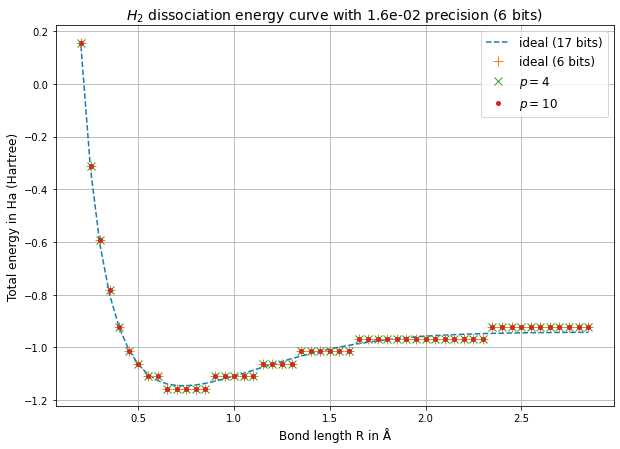

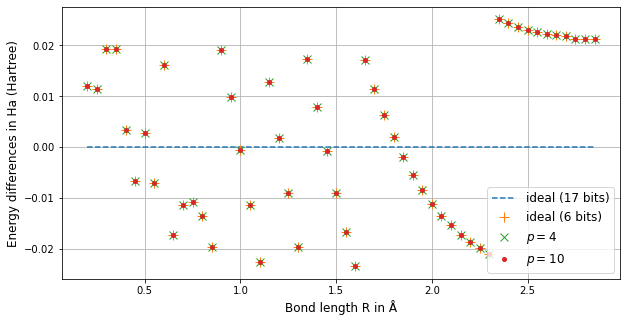

In [13]:
data_vals = read_from_file('data_6_bit.json')
# these are the ideal 17 bits values
values_perfect = data_vals['vals_perfect']
plot_energy(data_vals, 6)
plot_energy_diff(data_vals, 6)

<hr>

#### 8 bits

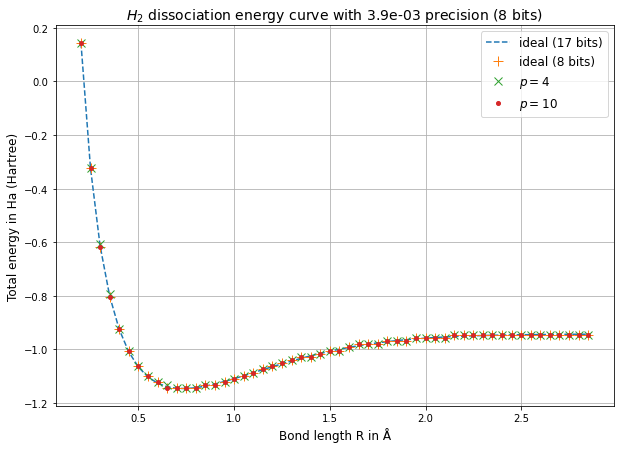

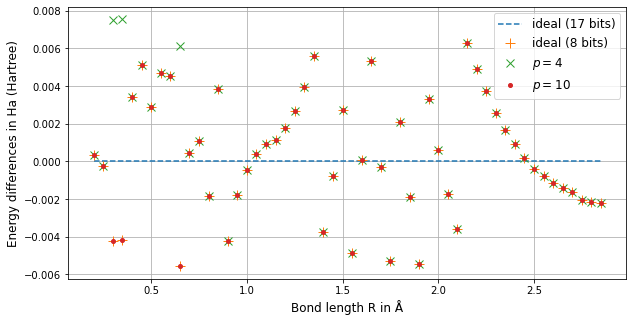

In [14]:
data_vals = read_from_file('data_8_bit.json')
data_vals['vals_perfect'] = values_perfect 
plot_energy(data_vals, 8)
plot_energy_diff(data_vals, 8)

<hr>

#### 10 bits

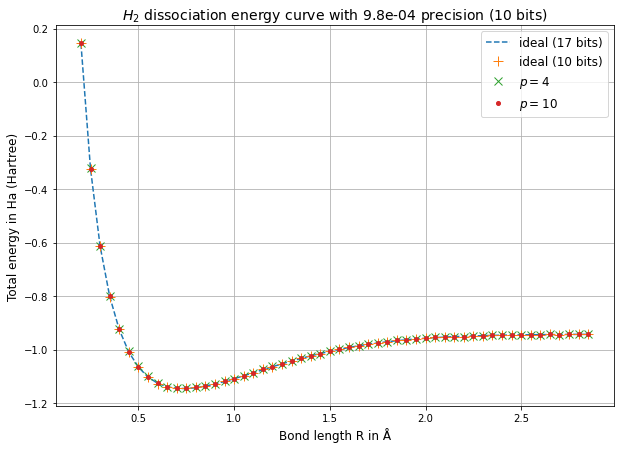

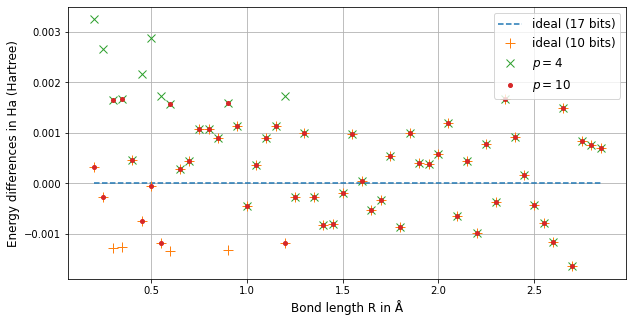

In [15]:
data_vals = read_from_file('data_10_bit.json')
data_vals['vals_perfect'] = values_perfect 
plot_energy(data_vals, 10)
plot_energy_diff(data_vals, 10)

<hr>

#### 12 bits

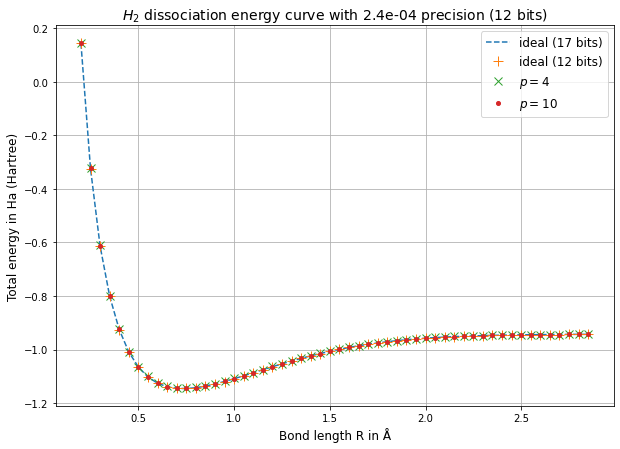

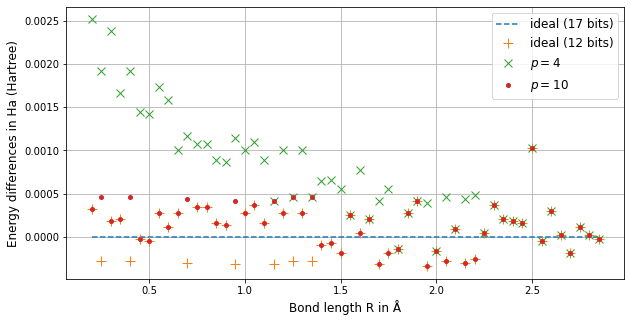

In [16]:
data_vals = read_from_file('data_12_bit.json')
# data_vals['vals_perfect'] = values_perfect 
plot_energy(data_vals, 12)
plot_energy_diff(data_vals, 12)

### 6.4 DISCUSSION <a id="6-4" href="#toc">$\Uparrow$</a>

* We successfully obtained the right curve for dissociation energy of $H_2$.
* When the precision (bit depth $N_{bits}$) of the phase estimate is to low, quantization (of the number) has a much larger impact on the result than the implementation of the evolution.
* When the precision increases (here arround or above 10 bits) we see the expected behaviour : full hamiltonian and high Trotter number are both close to the actual value while low Trotter number is a bit further.

<hr>

### 6.5 NEW RESULTS of the above simulation <a id="6-5" href="#toc">$\Uparrow$</a>

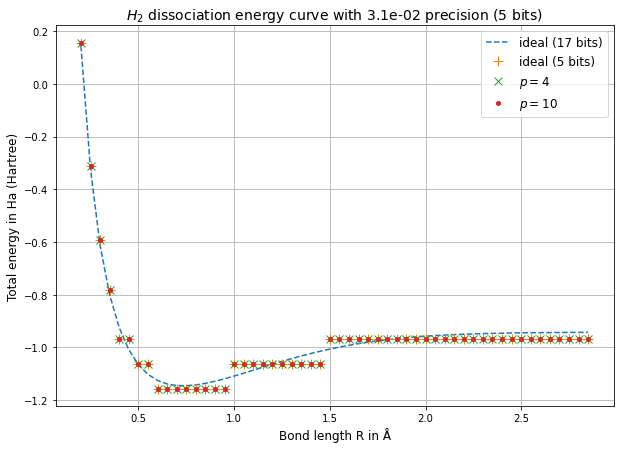

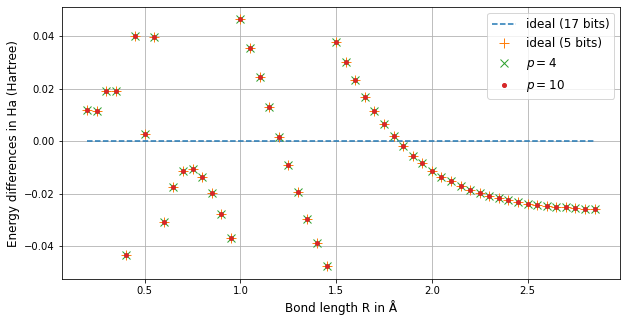

In [17]:
data_vals_new['vals_perfect'] = values_perfect 
plot_energy(data_vals_new, Nbits)
plot_energy_diff(data_vals_new, Nbits)